# Visualising clusters on the Iris dataset

It can sometimes be a bit difficult to understand what's going on without a good plot, so I wanted to start trying to visualise structures vs cluster definition on the Iris dataset. This will involve building the network structure and then querying the joint distribution of petal width, petal length, sepal width and sepal length given a discrete variable; the joint distribution will be a Gaussian mixture model.

The Python SDK is currently a bit limited for 'custom' queries, so currently only supports a Gaussian mixture query, with multiple continuous variables as the head variables, and a single discrete variable for the tail, e.g. P(petallength, sepalwidth, sepallength, petalwidth | irisclass). Bayes Server obviously supports a lot more.

First off, imports plus some code for plotting ellipses based upon a covariance matrix.

In [7]:
%matplotlib notebook

import pandas as pd

import sys
sys.path.append("../../../bayesianpy")

import bayesianpy
from bayesianpy.network import Builder as builder

import logging
import os

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Using the latent variable to cluster data points. Based upon the Iris dataset which has 3 distinct clusters
# (not all of which are linearly separable). Using a joint probability distribution, first based upon the class
# variable 'iris_class' and subsequently the cluster variable as a tail variable. Custom query currently only supports
# a single discrete tail variable and multiple continuous head variables.

jd = bayesianpy.visual.JointDistribution()
def plot(head_variables, results):

    fig = plt.figure(figsize=(10, 10))
    n = len(head_variables)-1
    total = n*(n+1)/2

    k = 1
    for i, hv in enumerate(head_variables):
        for j in range(i + 1, len(head_variables)):
            ax = fig.add_subplot(total/2, 2, k)
            jd.plot_distribution_with_covariance(ax, iris,
                                                       (head_variables[i], head_variables[j]), results)

            k+=1
    plt.show()

Next, just a bit of setup code to load the data and setup the Jpype instance.

In [8]:
logger = logging.getLogger()
logger.addHandler(logging.StreamHandler())
logger.setLevel(logging.INFO)

bayesianpy.jni.attach(logger)

db_folder = bayesianpy.utils.get_path_to_parent_dir("")
iris = pd.read_csv(os.path.join(db_folder, "data/iris.csv"), index_col=False)

## Naive Bayes

The next step is creating the model by hand. The Python SDK also supports multivariate nodes, but for clarity each node is individually stored here. This is not a fully connected model, as the continuous nodes are only connected through the cluster.

<IPython.core.display.Javascript object>


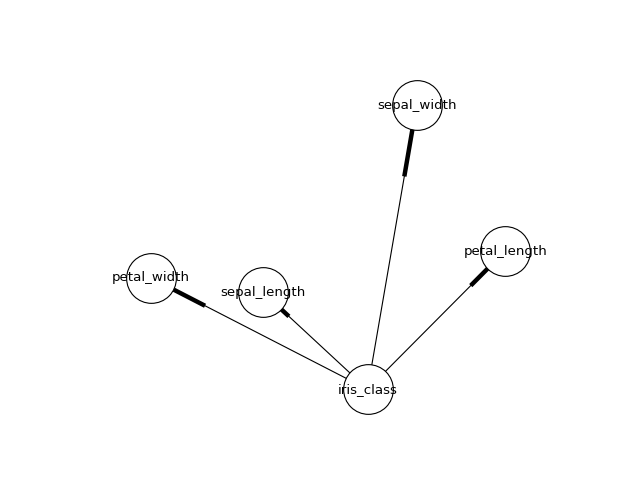

In [9]:
network = bayesianpy.network.create_network()

petal_length = builder.create_continuous_variable(network, "petal_length")
petal_width = builder.create_continuous_variable(network, "petal_width")
sepal_length = builder.create_continuous_variable(network, "sepal_length")
sepal_width = builder.create_continuous_variable(network, "sepal_width")
nodes = [petal_length, petal_width, sepal_length, sepal_width]
class_variable = builder.create_discrete_variable(network, iris, 'iris_class', iris['iris_class'].unique())

for i, node in enumerate(nodes):
    builder.create_link(network, class_variable, node)

plt.figure()
layout = bayesianpy.visual.NetworkLayout(network)
graph = layout.build_graph()
pos = layout.fruchterman_reingold_layout(graph)
layout.visualise(graph, pos)

The network still needs training, so kick that off.

In [10]:
with bayesianpy.data.DataSet(iris, db_folder, logger) as dataset:
    model = bayesianpy.model.NetworkModel(network, logger)
    model.train(dataset)

INFO:root:Writing 150 rows to storage
Writing 150 rows to storage
Writing 150 rows to storage
INFO:root:Finished writing 150 rows to storage
Finished writing 150 rows to storage
Finished writing 150 rows to storage
INFO:root:Training model...
Training model...
Training model...
INFO:root:Finished training model
Finished training model
Finished training model


Now it gets interesting, as we can query the priors that the network has setup. GaussianMixtureQuery returns the same format of covariance matrix that would be output by numpy.conv.

INFO:root:Writing 150 rows to storage
Writing 150 rows to storage
Writing 150 rows to storage
INFO:root:Finished writing 150 rows to storage
Finished writing 150 rows to storage
Finished writing 150 rows to storage


<IPython.core.display.Javascript object>


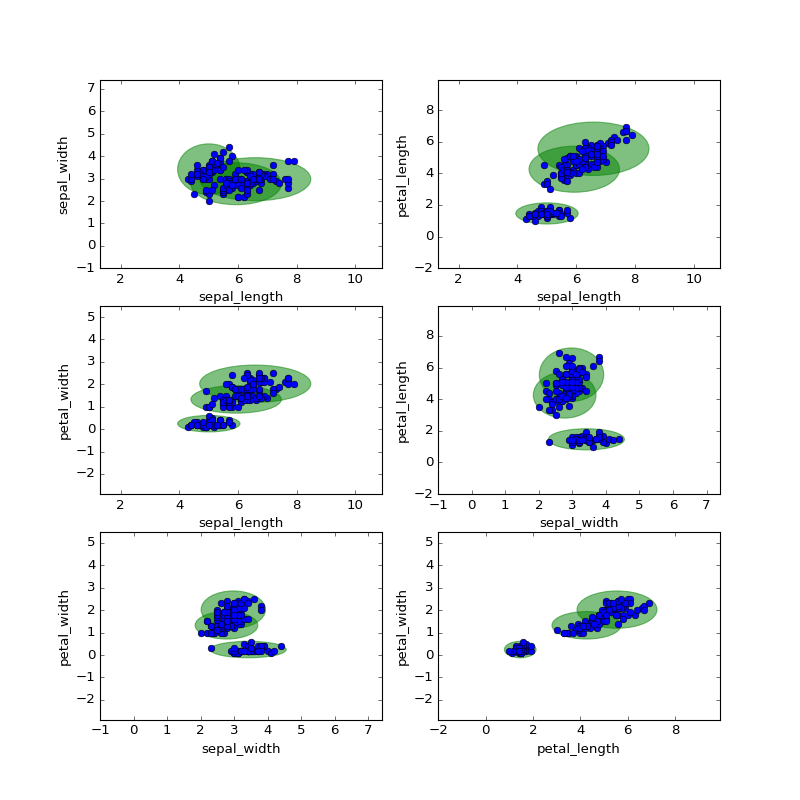

In [11]:
with bayesianpy.data.DataSet(iris, db_folder, logger) as dataset:
    head_variables = ['sepal_length','sepal_width','petal_length','petal_width']

    query_type_class = bayesianpy.model.QueryConditionalJointProbability(
            head_variables=head_variables,
                tail_variables=['iris_class'])

    engine = bayesianpy.model.InferenceEngine(network).create_engine()
    
    # pass in an inference engine so that multiple queries can be performed, or evidence can be set.
    query = bayesianpy.model.Query(network, engine, logger)
    results_class = query.execute([query_type_class], aslist=False)

    plot(head_variables, results_class)

Performance doesn't seem too bad with the naive Bayes model, however it's possible to note that the ellipses have 0 covariance, as each variable is independent of the other (apart from iris_class). To improve performance, the variables could be fully connected.

## Fully observed mixture model

<IPython.core.display.Javascript object>


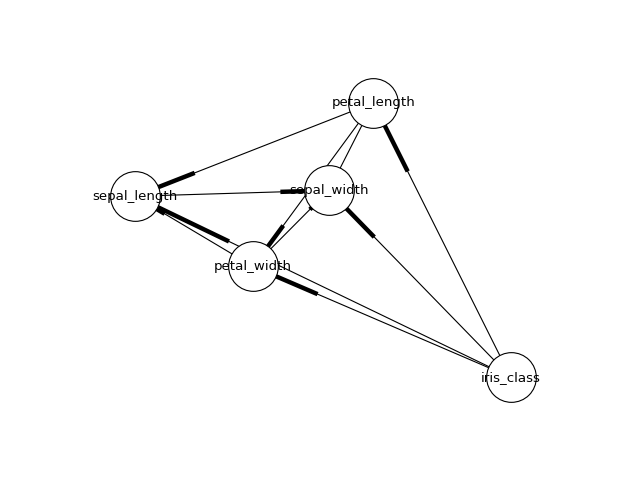

In [12]:
network = bayesianpy.network.create_network()

petal_length = builder.create_continuous_variable(network, "petal_length")
petal_width = builder.create_continuous_variable(network, "petal_width")
sepal_length = builder.create_continuous_variable(network, "sepal_length")
sepal_width = builder.create_continuous_variable(network, "sepal_width")
nodes = [petal_length, petal_width, sepal_length, sepal_width]
class_variable = builder.create_discrete_variable(network, iris, 'iris_class', iris['iris_class'].unique())

for i, node in enumerate(nodes):
    builder.create_link(network, class_variable, node)
    for j in range(i+1, len(nodes)):
        builder.create_link(network, node, nodes[j])

plt.figure()
layout = bayesianpy.visual.NetworkLayout(network)
graph = layout.build_graph()
pos = layout.fruchterman_reingold_layout(graph)
layout.visualise(graph, pos)

INFO:root:Writing 150 rows to storage
Writing 150 rows to storage
Writing 150 rows to storage
INFO:root:Finished writing 150 rows to storage
Finished writing 150 rows to storage
Finished writing 150 rows to storage
INFO:root:Training model...
Training model...
Training model...
INFO:root:Finished training model
Finished training model
Finished training model


<IPython.core.display.Javascript object>


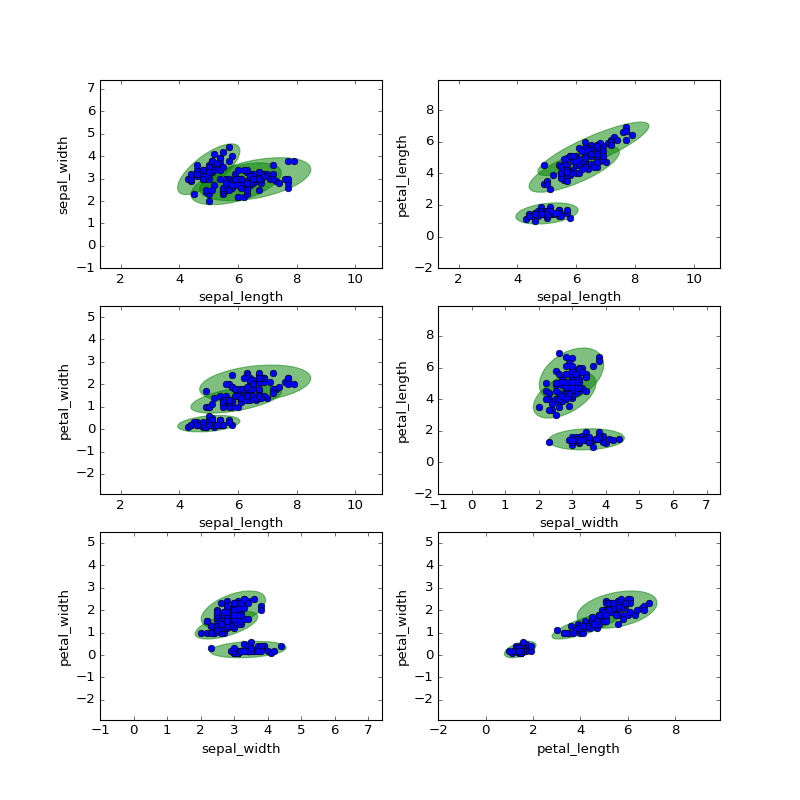

In [13]:
with bayesianpy.data.DataSet(iris, db_folder, logger) as dataset:
    model = bayesianpy.model.NetworkModel(network, logger)
    model.train(dataset)
    
    head_variables = ['sepal_length','sepal_width','petal_length','petal_width']

    query_type_class = bayesianpy.model.QueryConditionalJointProbability(
            head_variables=head_variables,
                tail_variables=['iris_class'])

    engine = bayesianpy.model.InferenceEngine(network).create_engine()
    
    # pass in an inference engine so that multiple queries can be performed, or evidence can be set.
    query = bayesianpy.model.Query(network, engine, logger)
    results_class = query.execute([query_type_class], aslist=False)

    plot(head_variables, results_class)

As can be seen, the ellipses are no longer axis aligned and now covary accordingly. If there are more than three clusters, and only three classes, then a latent variable can be used.